## Build a Predictive model to be used for labeling yelp reviews sentiment and its authenticity.
* The Moview reviews data is used to build the model for both sentiment classification and authenticity classification.
* The Moview reviews data has sentiment label and authenticity label.
* The model will be saved in a pickle object and will be used to predict label for yelp reviews


### Load Packages

In [0]:

## import packages
import pandas as pd # for tabular data manipulation
import numpy as np  # for numeric computing
import matplotlib.pyplot as plt  # for data visualization
import seaborn as sns # visulization

from sklearn.naive_bayes import MultinomialNB  #Mulitinomial Naive bayes implementation in sklearn
from sklearn.naive_bayes import BernoulliNB    #BernoulliNB implementation in sklear
from sklearn.svm import LinearSVC

#vectoriation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split  #splitting data to train and test set

from sklearn.model_selection import cross_val_score   #model evaluation

from sklearn.pipeline import Pipeline # create a model pipeline

from sklearn.metrics import confusion_matrix  # confusion matrix, model evaluation

import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk.stem


%matplotlib inline

### Mont gdrive 
The movie reviews data is saved in the gdrive and the model will also be saved in the gdrive

In [2]:
#Mount the gdrive
from google.colab import drive
drive.mount('/content/drive')


#change directry to the gdrive
os.chdir('./drive/My Drive/Colab Notebooks/code')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Load Data

In [4]:
## Load datasets

deception = pd.read_csv('../data/deception_data_converted_final.csv')

deception.head()

,lie,sentiment,review,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,f,n,'Mike\'s Pizza High Point,NY Service was very slow and the quality was ...,not. Stick to pre-made dishes like stuffed pa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f,n,'i really like this buffet restaurant in Marsh...,japanese,and chinese dishes. we also got a free drink ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f,n,'After I went shopping with some of my friend,we went to DODO restaurant for dinner. I foun...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f,n,'Olive Oil Garden was very disappointing. I ex...,and the waitor had no manners whatsoever. Don...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f,n,'The Seven Heaven restaurant was never known f...,never more. ',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Observation: There are three columns in the datasets. lie, sentiment and reviews. Other unnamed columns are part of the customer reviews. This columns will be concatenated together and strip off the NaN, to make up the customer reviews columns

In [5]:

##check the columns
print(deception.columns)

Index(['lie', 'sentiment', 'review', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')


* Combined all the reviews columns together.

In [0]:

## columns that might have some reviews data 

col = ['Unnamed: 3','Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23']

* Concat all the columns to the reviews

In [11]:
##concat
for c in col:
  deception['review'] = deception['review'].astype(str).str.cat(deception[c].astype(str), sep=' ')
  

## dropunwanted columns
deception.drop(col,axis=1, inplace=True)

deception.head()

,lie,sentiment,review
0,f,n,'Mike\'s Pizza High Point NY Service was very...
1,f,n,'i really like this buffet restaurant in Marsh...
2,f,n,'After I went shopping with some of my friend ...
3,f,n,'Olive Oil Garden was very disappointing. I ex...
4,f,n,'The Seven Heaven restaurant was never known f...


* Check the first customer review

In [10]:

print(deception['review'][0])

'Mike\'s Pizza High Point  NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza  not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan  NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza  not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan



we have two labels for the customer review, the lie and sentiment

check the number of categories for each label

In [12]:
deception.lie.value_counts()

f    46
t    46
Name: lie, dtype: int64

In [13]:
deception.sentiment.value_counts()

n    46
p    46
Name: sentiment, dtype: int64

Clean Text

Collect all the text in a list and clean the contents by removing stop words, NaN

In [14]:

allText = deception['review'].values
allText[:2]

array(["'Mike\\'s Pizza High Point  NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza  not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan  NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza  not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan  NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza  not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where.' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan",
       "'i really like this buffet restaurant in Marshall street. they have a lot of

In [15]:
newText = []

for line in allText:
    ### More cleaning....
    line=line.replace("\\n","")
    #print(line)
    line=line.strip("\\n")
    line=line.replace("\\'","")
    line=line.replace("\\","")
    line=line.replace('"',"")
    line=line.replace("'","")
    line=line.replace("s'","")
    line=line.lstrip()
    line =line.replace('nan','')
    line =line.replace('na','')
    line =line.replace('.','')
    line =line.replace('!','')
    line =line.replace('(','')
    line =line.replace(')','')
    line =line.replace('   ','')
    #print(line)
    newText.append(line)
      
    
newText[:5]  #the clean text

['Mikes Pizza High Point  NY Service was very slow and the quality was low You would think they would know at least how to make good pizza  not Stick to pre-made dishes like stuffed pasta or a salad You should consider dining else whereNY Service was very slow and the quality was low You would think they would know at least how to make good pizza  not Stick to pre-made dishes like stuffed pasta or a salad You should consider dining else whereNY Service was very slow and the quality was low You would think they would know at least how to make good pizza  not Stick to pre-made dishes like stuffed pasta or a salad You should consider dining else where ',
 'i really like this buffet restaurant in Marshall street they have a lot of selection of american  japanese  and chinese dishes we also got a free drink and free refill there are also different kinds of dessert the staff is very friendly it is also quite cheap compared with the other restaurant in syracuse area i will definitely coming b

In [16]:
## add clean text to dataframe
deception['cleanreview'] = newText
deception.head()

,lie,sentiment,review,cleanreview
0,f,n,'Mike\'s Pizza High Point NY Service was very...,Mikes Pizza High Point NY Service was very sl...
1,f,n,'i really like this buffet restaurant in Marsh...,i really like this buffet restaurant in Marsha...
2,f,n,'After I went shopping with some of my friend ...,After I went shopping with some of my friend ...
3,f,n,'Olive Oil Garden was very disappointing. I ex...,Olive Oil Garden was very disappointing I expe...
4,f,n,'The Seven Heaven restaurant was never known f...,The Seven Heaven restaurant was never known fo...


In [0]:
## function to generate word cloud

def generate_wordcloud(text, max_font_size=80, max_words=100, background_color="white"):
    '''generate word cloud from text '''
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    #display generated image
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    #figname = str(text) + '.png'
    #plt.savefig(figname)
    plt.show()

Wordcloud of the reviews

Wordcloud of False Reviews

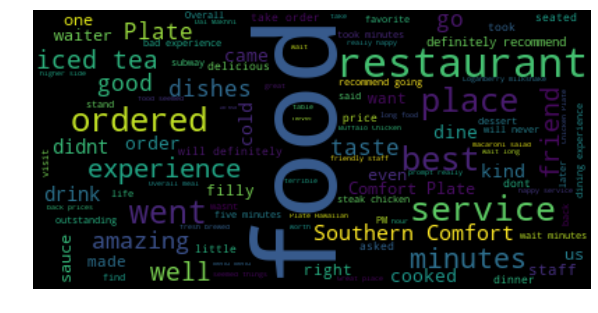

In [18]:
#create a wordclod of the false text
ftext = ''

#deception['newreview'][1]

for i in range(len(deception)):
  if deception['lie'][i] == 'f':
    ftext = ftext + deception['cleanreview'][i]
    
    
    
generate_wordcloud(ftext,background_color='black')

* Wordcloud for true customer reviews

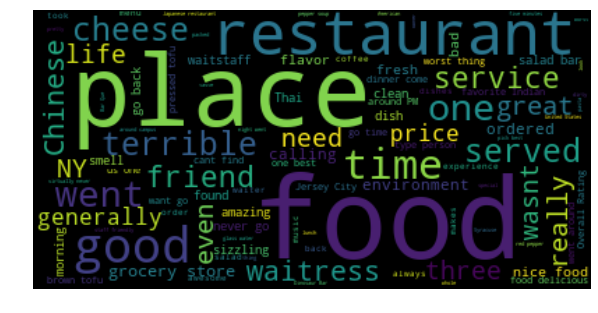

In [19]:
#create a wordclod of the false text
ttext = ''

#deception['newreview'][1]

for i in range(len(deception)):
  if deception['lie'][i] == 't':
    ttext = ttext + deception['cleanreview'][i]
    
    
    
generate_wordcloud(ttext,background_color='black')

* 
Create a wordcloud for positive sentiment

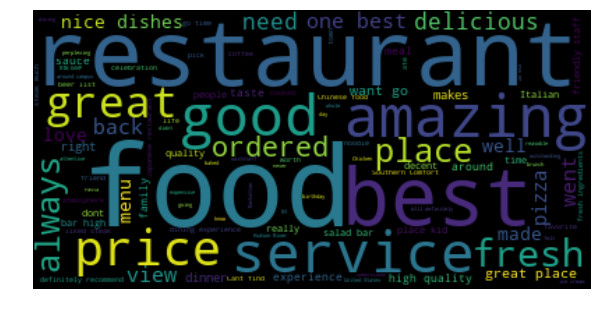

In [20]:
#create a wordclod for positive sentiment
ptext = ''

#deception['newreview'][1]

for i in range(len(deception)):
  if deception['sentiment'][i] == 'p':
    ptext = ptext + deception['cleanreview'][i]
    
    
    
generate_wordcloud(ptext,background_color='black')

* Create a wordcloud for negative sentiment

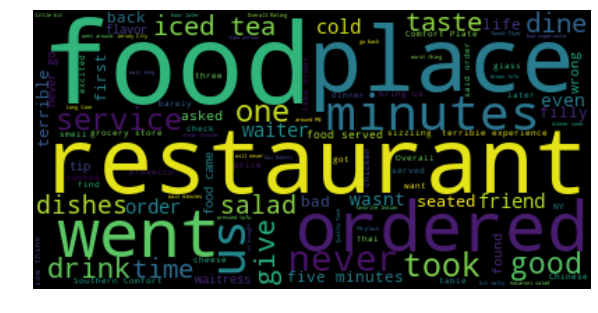

In [21]:
#create a wordclod for negative sentiment
ntext = ''

#deception['newreview'][1]

for i in range(len(deception)):
  if deception['sentiment'][i] == 'n':
    ntext = ntext + deception['cleanreview'][i]
    
    
    
generate_wordcloud(ntext,background_color='black')

###  Split the datasets  into Train and Test set¶

In [24]:
train,test = train_test_split(deception, test_size=0.2, random_state=0)

print('test shape: {}'.format(test.shape))
print('train shape: {}'.format(train.shape))

## check the label classes in both train and test set
print('='*50)
print("===Train Lie Value Counts===")
print(train.lie.value_counts())
print("===Train Sentiment Value Counts===")
print(train.sentiment.value_counts())

print("===Test Lie Value Count===")
print(test.lie.value_counts())
print("===Test Sentiment Value Counts===")
print(test.sentiment.value_counts())

test shape: (19, 4)
train shape: (73, 4)
===Train Lie Value Counts===
t    37
f    36
Name: lie, dtype: int64
===Train Sentiment Value Counts===
p    38
n    35
Name: sentiment, dtype: int64
===Test Lie Value Count===
f    10
t     9
Name: lie, dtype: int64
===Test Sentiment Value Counts===
n    11
p     8
Name: sentiment, dtype: int64


###  Vectorization

In [25]:
## cleanreviews from train datasets

myList = train.cleanreview.values

print("Before")
print(type(myList))
myList = list(myList)
print("After")
print(type(myList))

Before
<class 'numpy.ndarray'>
After
<class 'list'>


In [0]:
# myList[:5]

## Vectorization

#  unigram boolean vectorizer, set minimum document frequency to 5
unigram_bool_vectorizer = CountVectorizer(input="content",encoding='latin-1', binary=True, min_df=5, stop_words='english')

#  unigram term frequency vectorizer, set minimum document frequency to 5
unigram_count_vectorizer = CountVectorizer(input="content",encoding='latin-1', binary=False, min_df=5, stop_words='english')

#  unigram and bigram term frequency vectorizer, set minimum document frequency to 5
gram12_count_vectorizer = CountVectorizer(input="content",encoding='latin-1', ngram_range=(1,2), min_df=5, stop_words='english')

#  unigram tfidf vectorizer, set minimum document frequency to 5
unigram_tfidf_vectorizer = TfidfVectorizer(input="content",encoding='latin-1', use_idf=True, min_df=5, stop_words='english')

Unigram Bool Vectorizer

In [27]:

## fit transform the text to bool vectorizer
bool_vec = unigram_bool_vectorizer.fit_transform(myList)

## Get feature names
bool_features = unigram_bool_vectorizer.get_feature_names()

## create a dataframe
bool_df = pd.DataFrame(bool_vec.toarray(), columns=bool_features )
bool_df.head()

,amazing,ask,asked,bad,bar,best,called,came,chicken,chinese,cold,definitely,delicious,didnt,dine,dining,dinner,dish,dishes,dont,environment,experience,favorite,food,fresh,friendly,friends,going,good,great,high,just,later,life,like,long,meal,menu,minutes,need,nice,ny,order,ordered,overall,people,place,prices,quality,really,restaurant,said,salad,sauce,served,service,staff,table,taste,terrible,time,took,wait,waiter,waiters,waitress,want,wasnt,went,worth
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Unigram Count Vectorizer

In [28]:
## Fit transform the text to count vectorizer
count_vec = unigram_count_vectorizer.fit_transform(myList)

## get feature names
count_features = unigram_count_vectorizer.get_feature_names()

## create dataframe
count_df = pd.DataFrame(count_vec.toarray(), columns=count_features)
count_df.head()

,amazing,ask,asked,bad,bar,best,called,came,chicken,chinese,cold,definitely,delicious,didnt,dine,dining,dinner,dish,dishes,dont,environment,experience,favorite,food,fresh,friendly,friends,going,good,great,high,just,later,life,like,long,meal,menu,minutes,need,nice,ny,order,ordered,overall,people,place,prices,quality,really,restaurant,said,salad,sauce,served,service,staff,table,taste,terrible,time,took,wait,waiter,waiters,waitress,want,wasnt,went,worth
0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,4,0
1,0,0,0,0,4,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,9,0,0,1,0,3,0,0,6,0,0,0,0,0,0,3,0,0,0,0,0,0,9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,3,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0


Ngrams(1,2) Count Vectorizer

In [29]:
## fit tranform the text to ngrams(1,2) vectorizer
ngram_vec = gram12_count_vectorizer.fit_transform(myList)

## get feature names
ngram_features = gram12_count_vectorizer.get_feature_names()

## create ngram dataframe
ngram_df = pd.DataFrame(ngram_vec.toarray(), columns=ngram_features)
ngram_df.head()

,amazing,ask,asked,bad,bar,best,called,came,chicken,chinese,cold,definitely,delicious,didnt,dine,dining,dinner,dish,dishes,dont,environment,experience,favorite,food,fresh,friendly,friends,going,good,great,high,just,later,life,like,long,meal,menu,minutes,need,nice,ny,order,ordered,overall,people,place,prices,quality,really,restaurant,said,salad,sauce,served,service,staff,table,taste,terrible,time,took,wait,waiter,waiters,waitress,want,wasnt,went,worth
0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,4,0
1,0,0,0,0,4,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,9,0,0,1,0,3,0,0,6,0,0,0,0,0,0,3,0,0,0,0,0,0,9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,3,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0


TF*IDF Vectorizer

In [30]:
## fit transform the text using tf*idf vectorizer
tfidf_vec = unigram_tfidf_vectorizer.fit_transform(myList)

## get feature names
tfidf_features = unigram_tfidf_vectorizer.get_feature_names()

## create dataframe
tfidf_df = pd.DataFrame(tfidf_vec.toarray(), columns=tfidf_features)
tfidf_df.head()

,amazing,ask,asked,bad,bar,best,called,came,chicken,chinese,cold,definitely,delicious,didnt,dine,dining,dinner,dish,dishes,dont,environment,experience,favorite,food,fresh,friendly,friends,going,good,great,high,just,later,life,like,long,meal,menu,minutes,need,nice,ny,order,ordered,overall,people,place,prices,quality,really,restaurant,said,salad,sauce,served,service,staff,table,taste,terrible,time,took,wait,waiter,waiters,waitress,want,wasnt,went,worth
0,0.0,0.0,0.0,0.396851,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.383393,0.0,0.0,0.0,0.0,0.0,0.0,0.197077,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.349880,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.396851,0.000000,0.0,0.0,0.0,0.200083,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.127798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428952,0.369335,0.0
1,0.0,0.0,0.0,0.000000,0.329946,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.218892,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.326108,0.0,0.0,0.064328,0.000000,0.152787,0.000000,0.0,0.385969,0.0,0.0,0.000000,0.0,0.0,0.000000,0.198624,0.0,0.0,0.0,0.0,0.000000,0.0,0.656677,0.299576,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.105129,0.0,0.0,0.000000,0.000000,0.000000,0.933198,0.0,0.186640,0.0,0.0,0.164466,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.211696,0.000000,0.0,0.0,0.0,0.106732,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.394561,0.00000,0.000000,0.412672,0.365033,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.241702,0.0,0.0,0.000000,0.378872,0.000000,0.000000,0.0,0.107276,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.429104,0.0,0.000000,0.000000,0.0,0.0,0.0,0.061347,0.0,0.0,0.0,0.0,0.088494,0.0,0.0,0.000000,0.352654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084931,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.262533,0.000000,0.24103,0.262533,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.541246,0.0,0.0,0.210723,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.117083,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.673051,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0



Get the Labels

* Lie 
* Sentiment

In [31]:
## lie label for train data
lie_label = train.lie.values

## sentiment label for the train data
sentiment_label = train.sentiment.values

## print some of the lie label
print(lie_label[:5])

## print some of the sentiment label
print(sentiment_label[:5])

['t' 't' 'f' 'f' 't']
['n' 'n' 'p' 'n' 'n']


### Create pipeline for cross validation

In [0]:
## create a pipeline
def score_model_pipeline(model, vectorizer, X,y, cv=5):
  nbc = Pipeline([('vect', vectorizer), ('nb', model)])
  scores = cross_val_score(nbc, X,y,cv=cv)
  print('Avg Score: {}'.format(sum(scores)/len(scores)))
  
  

**Bool**

In [34]:
## Score the model using cross validation of 10. Using the whole training sets
score_model_pipeline(BernoulliNB(),unigram_bool_vectorizer,myList, lie_label, cv=10 )

Avg Score: 0.5190476190476191


**Using Count Vectorizer**

In [35]:
## Score the model using cross validation of 10. Using the whole training sets
score_model_pipeline(BernoulliNB(),unigram_count_vectorizer,myList, lie_label, cv=10 )

Avg Score: 0.5190476190476191


**Ngram**

In [36]:
## Score the model using cross validation of 10. Using the whole training sets
score_model_pipeline(BernoulliNB(),gram12_count_vectorizer,myList, lie_label, cv=10 )

Avg Score: 0.5190476190476191


**Tfidf**

In [37]:
## Score the model using cross validation of 10. Using the whole training sets
score_model_pipeline(BernoulliNB(),unigram_tfidf_vectorizer,myList, lie_label, cv=10 )

Avg Score: 0.5190476190476191


In [38]:
## create a model container
model = {}

## add benoulli and multinomial naives to the model cointainer
model['BNB'] = BernoulliNB()
model['MNB'] = MultinomialNB()

## create a vectorization container
vec = {}

## add vectorizer to the container
vec['bool'] = CountVectorizer(input="content",encoding='latin-1', binary=True, min_df=5, stop_words='english')
vec['count'] =  CountVectorizer(input="content",encoding='latin-1', binary=False, min_df=5, stop_words='english')
vec['ngram'] = CountVectorizer(input="content",encoding='latin-1', ngram_range=(1,2), min_df=5, stop_words='english')
vec['tfidf'] = TfidfVectorizer(input="content",encoding='latin-1', use_idf=True, min_df=5, stop_words='english')

## 10 fold cross validation function
## create a pipeline
def score_model_pipeline(model, vectorizer, X,y, cv=10):
  '''10 fold cross validation pipeline and return the average scores'''
  nbc = Pipeline([('vect', vectorizer), ('nb', model)])
  scores = cross_val_score(nbc, X,y,cv=cv)
  print('Avg Score: {}'.format(sum(scores)/len(scores)))
  return sum(scores)/len(scores)


## get features and label from dataframe
def get_X_y_from_df(df, X='text', y='label'):
  '''get the text,features and the label, the target. return features and target'''
  X = list(df[X].values)
  y = df[y].values
  return X,y


## create an emty list to store score
score = []
vec_use = []
model_use= []

## get X and y
X,y = get_X_y_from_df(deception, X='cleanreview', y='lie')

## run the cross validation using the pipeline
for mod in model:
  # loop through the model in the model container
  for v in vec:
    # loop through the vectorizer in the vectorizer container
    cv = score_model_pipeline(model[mod], vec[v], X,y)
    score.append(cv)  # append the score
    vec_use.append(v)  # append the vectorization used
    model_use.append(mod) # append the model used
    
    
  
## create a date frame of cross validation score of the classifier
result = {'Model': model_use, 'Vectorization': vec_use, '10 fold Avg Score': score}
lie_df = pd.DataFrame(result)
lie_df

Avg Score: 0.57
Avg Score: 0.57
Avg Score: 0.5599999999999999
Avg Score: 0.57
Avg Score: 0.53
Avg Score: 0.5599999999999999
Avg Score: 0.5599999999999999
Avg Score: 0.5125


,Model,Vectorization,10 fold Avg Score
0,BNB,bool,0.5700
1,BNB,count,0.5700
2,BNB,ngram,0.5600
3,BNB,tfidf,0.5700
4,MNB,bool,0.5300
5,MNB,count,0.5600
6,MNB,ngram,0.5600
7,MNB,tfidf,0.5125


**Train the model with the whole datasets and save it as a pickle object**

In [39]:
## vec
train_vec = unigram_bool_vectorizer.fit_transform(deception['cleanreview'])

## feature names
features = unigram_bool_vectorizer.get_feature_names()

## get lie label
target_label = deception['lie'].values


## initialize the model
final_model = BernoulliNB()

## fit the model
final_model.fit(train_vec,target_label )


## make prediction
lie_prediction = final_model.predict(train_vec)

## check the model performance
labels = ['t','f']
cm = confusion_matrix(lie_prediction, target_label,labels)

print(cm)

[[43 14]
 [ 3 32]]


**Save the model**

In [0]:
import pickle


# save the model to disk
filename = 'BNB-model-for-lie-detection-in-reviews.sav'
pickle.dump(final_model, open(filename, 'wb'))


# save the vectorizer
filename_vec = 'BNB-model-for-lie-detection-in-review-vectorizer.sav'
pickle.dump(unigram_bool_vectorizer, open(filename_vec, 'wb'))

### Sentiment Classification

In [42]:
## create a model container
model = {}

## add benoulli and multinomial naives to the model cointainer
model['BNB'] = BernoulliNB()
model['MNB'] = MultinomialNB()
model['SVM'] = LinearSVC()

## create a vectorization container
vec = {}

## add vectorizer to the container
vec['bool'] = CountVectorizer(input="content",encoding='latin-1', binary=True, min_df=5, stop_words='english')
vec['count'] =  CountVectorizer(input="content",encoding='latin-1', binary=False, min_df=5, stop_words='english')
vec['ngram'] = CountVectorizer(input="content",encoding='latin-1', ngram_range=(1,2), min_df=5, stop_words='english')
vec['tfidf'] = TfidfVectorizer(input="content",encoding='latin-1', use_idf=True, min_df=5, stop_words='english')

## 10 fold cross validation function
## create a pipeline
def score_model_pipeline(model, vectorizer, X,y, cv=10):
  '''10 fold cross validation pipeline and return the average scores'''
  nbc = Pipeline([('vect', vectorizer), ('nb', model)])
  scores = cross_val_score(nbc, X,y,cv=cv)
  print('Avg Score: {}'.format(sum(scores)/len(scores)))
  return sum(scores)/len(scores)



## get features and label from dataframe
def get_X_y_from_df(df, X='text', y='label'):
  '''get the text,features and the label, the target. return features and target'''
  X = list(df[X].values)
  y = df[y].values
  return X,y

## create an emty list to store score
score = []
vec_use = []
model_use= []

## get X and y
X,y = get_X_y_from_df(deception, X='cleanreview', y='sentiment')

## run the cross validation using the pipeline
for mod in model:
  # loop through the model in the model container
  for v in vec:
    # loop through the vectorizer in the vectorizer container
    cv = score_model_pipeline(model[mod], vec[v], X,y)
    score.append(cv)  # append the score
    vec_use.append(v)  # append the vectorization used
    model_use.append(mod) # append the model used
    
    
  
## create a date frame of cross validation score of the classifier
result = {'Model': model_use, 'Vectorization': vec_use, '10 fold Avg Score': score}
sentiment_df = pd.DataFrame(result)
sentiment_df

Avg Score: 0.7825
Avg Score: 0.7825
Avg Score: 0.7825
Avg Score: 0.7825
Avg Score: 0.7675
Avg Score: 0.7875
Avg Score: 0.7875
Avg Score: 0.7699999999999999
Avg Score: 0.705
Avg Score: 0.74
Avg Score: 0.75
Avg Score: 0.775


,Model,Vectorization,10 fold Avg Score
0,BNB,bool,0.7825
1,BNB,count,0.7825
2,BNB,ngram,0.7825
3,BNB,tfidf,0.7825
4,MNB,bool,0.7675
5,MNB,count,0.7875
6,MNB,ngram,0.7875
7,MNB,tfidf,0.7700
8,SVM,bool,0.7050
9,SVM,count,0.7400


## Feature Engineering

In [0]:
## function for negative detection

def has_negation(post):
    pattern_neg_1 = re.compile(r'\b(not|no|never)\b')
    pattern_neg_2 = re.compile(r'\b([a-z]+less)\b')
    if pattern_neg_1.search(post.lower()) or pattern_neg_2.search(post.lower()):
        return 1
    else: 
        return 0

In [0]:
from scipy import sparse

y=deception['sentiment']

pattern_neg = re.compile(r'\b(not|no|never)\b')
deception['neg'] = deception['cleanreview'].apply(lambda x: 1 if pattern_neg.search(x.lower()) else 0)

X_dense = deception[['neg']]
X_sparse = gram12_count_vectorizer.fit_transform(deception['cleanreview']).astype(float)
X = sparse.hstack([X_sparse, X_dense]).tocsr()

In [51]:

%%time
# test the model with negation detection

svm_model = LinearSVC()
scores = cross_val_score(svm_model, X, y, cv=3, n_jobs=3)
avg=sum(scores)/len(scores)
print(avg)

0.8166666666666668
CPU times: user 16.3 ms, sys: 26.2 ms, total: 42.6 ms
Wall time: 2.76 s


In [0]:
svm_model = LinearSVC()
svm_model.fit(X, y)

##########  

# save the model to disk
filenamesentiment = 'SVM-model-for-sentiment-classification-in-reviews.sav'
pickle.dump(svm_model, open(filenamesentiment, 'wb'))


# save the vectorizer
filename_vec_sen = 'SVM-model-for-sentiment-classification-in-review-vectorizer.sav'
pickle.dump(gram12_count_vectorizer, open(filename_vec_sen, 'wb'))
